In [ ]:
# https://www.blog.trainindata.com/probability-calibration-in-machine-learning/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [2]:
def compute_scores(y_true, y_pred_proba, name=None):
    """Compute a specific set of classification scores."""	
    scores = {
        'brier_score': brier_score_loss(y_true, y_pred_proba),
        'log_loss_score': log_loss(y_true, y_pred_proba),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }
    return pd.Series(scores).rename(name)

In [3]:
# Generate a binary classification dataset
X, y = make_classification(
    n_samples=10_000,
    n_classes=2,
    weights=[0.7, 0.3],
    random_state=42
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Train an SVM binary classifier (known to produce uncalibrated probabilities)
clf = SVC(kernel='rbf', random_state=42)
clf.fit(X_train, y_train)

# Get probability predictions (uncalibrated)
y_pred_proba = clf.decision_function(X_test)
y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

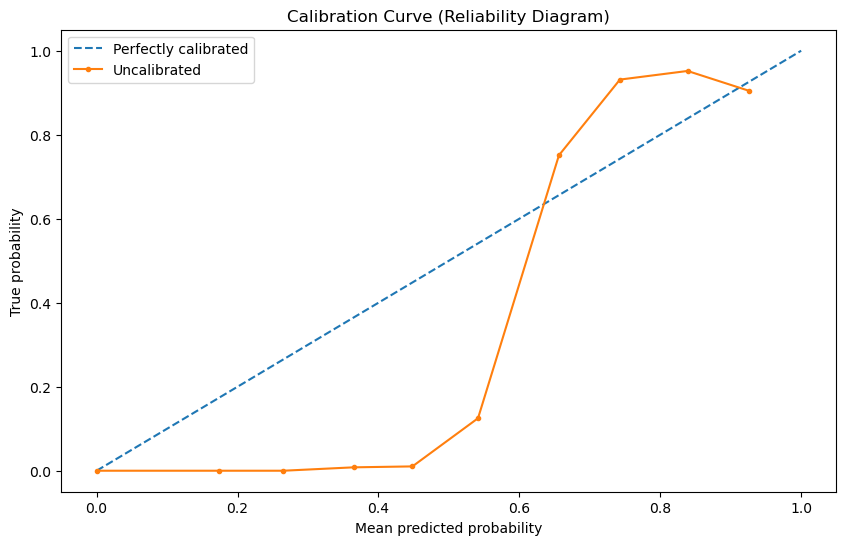

In [5]:
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# Calibration plot
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, marker='.', label='Uncalibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.show()

In [6]:
# Compute metrics for predictor
print(compute_scores(y_test, y_pred_proba, name='Uncalibrated'))

brier_score       0.177542
log_loss_score    0.539588
roc_auc           0.968339
Name: Uncalibrated, dtype: float64


In [7]:
# Calibrate using Platt Scaling
clf_platt = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
clf_platt.fit(X_train, y_train)

# Calibrate using Isotonic Regression
clf_isotonic = CalibratedClassifierCV(clf, cv=5, method='isotonic')
clf_isotonic.fit(X_train, y_train)

# Get calibrated probability predictions for both methods
y_pred_proba_platt = clf_platt.predict_proba(X_test)[:, 1]
y_pred_proba_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

In [8]:
# Calculate calibration curves
prob_true, prob_pred_uncal = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='quantile')

prob_true_platt, prob_pred_platt = calibration_curve(y_test, y_pred_proba_platt, n_bins=10, strategy='quantile')

prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_test, y_pred_proba_isotonic, n_bins=10, strategy='quantile')

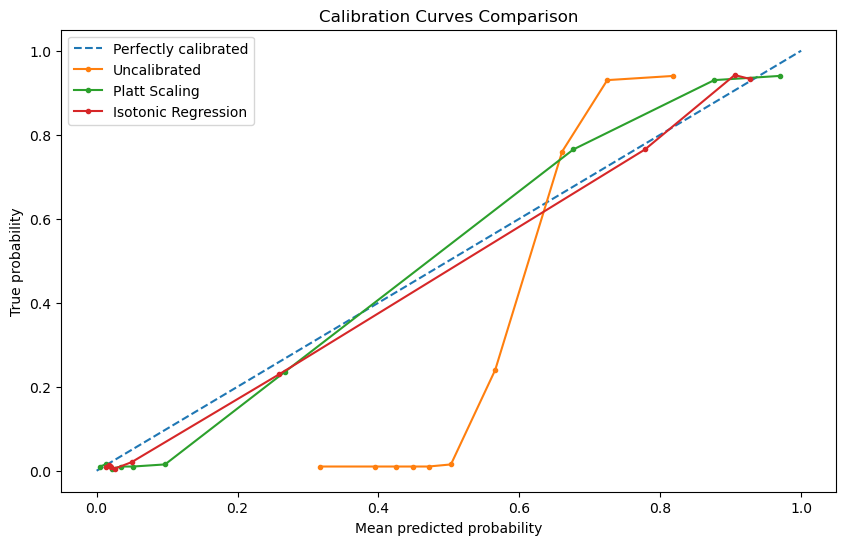

In [9]:
# Calibration plot
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.plot(prob_pred_uncal, prob_true, marker='.', label='Uncalibrated')
plt.plot(prob_pred_platt, prob_true_platt, marker='.', label='Platt Scaling')
plt.plot(prob_pred_isotonic, prob_true_isotonic, marker='.', label='Isotonic Regression')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curves Comparison')
plt.legend()
plt.show()

In [10]:
# Compute metrics for predictor
df_scores = pd.DataFrame([
    compute_scores(y_test, y_pred_proba, name='Uncalibrated'),
    compute_scores(y_test, y_pred_proba_platt, name='Platt Scaling'),
    compute_scores(y_test, y_pred_proba_isotonic, name='Isotonic Regression')
])

print(df_scores)

                     brier_score  log_loss_score   roc_auc
Uncalibrated            0.177542        0.539588  0.968339
Platt Scaling           0.053869        0.202653  0.968106
Isotonic Regression     0.051877        0.188629  0.967950
